In [1]:
import sys, os


import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random

In [2]:
from io import BytesIO
import palettable

In [3]:

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.sans-serif'] = ['Arial'] + ['DejaVu Sans',
                              'Bitstream Vera Sans',
                              'Computer Modern Sans Serif',
                              'Lucida Grande',
                              'Verdana',
                              'Geneva',
                              'Lucid',
                              'Arial',
                              'Helvetica',
                              'Avant Garde',
                              'sans-serif']

In [6]:
country_name = 'colombia'
country_abbrv = 'co'

In [ ]:
daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
daily_od = pd.read_csv(daily_od_fname)
geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}

In [8]:
unique_times = list(np.unique([row.local_time[-19:] for i, row in daily_od.iterrows()]))
str_time_dict = {t:i for i, t in enumerate(unique_times)}
daily_od['time_id'] = daily_od.local_time.apply(lambda x: str_time_dict[x[-19:]])
daily_od['m_length_km'] = daily_od.m_length_m/1000.
daily_od['neighbours'] = daily_od['start_geohash5'].apply(lambda x: geohash.neighbors(x))


In [ ]:
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')

In [10]:
daily_od['wtd_length'] = daily_od['m_length_m'] * daily_od['trip_count']
R = daily_od.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'trip_count':'mean',
                                                                            'wtd_length':'mean'}).reset_index()
    
R['trip_count'] = R['trip_count'].round().astype(int)

R['avg_len_real'] = R['wtd_length']/R['trip_count']
R['short'] = R['avg_len_real'].apply(lambda x: x<=5000)
R

,start_geohash5,end_geohash5,time_id,trip_count,wtd_length,avg_len_real,short
0,d0rfr,d0rfr,2,15,155694.840155,10379.656010,False
1,d0rfr,d0rfr,3,16,34268.598823,2141.787426,True
2,d0rfr,d0rfr,4,15,31539.753607,2102.650240,True
3,d0rfr,d0rfr,5,19,45297.433983,2384.075473,True
4,d0rfr,d0rfr,6,15,29173.206005,1944.880400,True
...,...,...,...,...,...,...,...
4684,d9050,d9050,3,12,24519.187908,2043.265659,True
4685,d9050,d9050,4,13,18241.451971,1403.188613,True
4686,d9050,d9050,5,11,17105.166036,1555.015094,True
4687,d9050,d9050,6,10,38151.952298,3815.195230,True


In [ ]:
compare_cities = minio_helper.read_file('netmob_2024/processed_data/compare_cities.csv', obj_type='csv').drop('Unnamed: 0', axis=1)
compare_cities.columns = ['city', 'urban', 'rural']
compare_cities['ur_diff'] = compare_cities['urban']- compare_cities['rural']
compare_cities = compare_cities.sort_values('ur_diff')
compare_cities = compare_cities.set_index('city')
compare_cities = compare_cities.loc[['Cartagena', 'Medellin', 'Cali', 'Bogota',
                                     'Mumbai', 'New Delhi', 'Bengaluru', 'Hyderabad',
                                     'Monterrey','Queretaro', 'CDMX', 'Guadalajara']].reset_index()


In [12]:
compare_cities.index

RangeIndex(start=0, stop=12, step=1)

In [75]:
compare_cities

,city,urban,rural,ur_diff
0,Cartagena,0.771176,0.801691,-0.030514
1,Medellin,0.796815,0.774782,0.022033
2,Cali,0.767810,0.740925,0.026884
3,Bogota,0.742266,0.704928,0.037338
4,Mumbai,0.790893,0.790288,0.000604
5,New Delhi,0.719921,0.717951,0.001970
6,Bengaluru,0.739280,0.737236,0.002044
7,Hyderabad,0.726935,0.708660,0.018275
8,Monterrey,0.777732,0.784670,-0.006938
9,Queretaro,0.794586,0.798361,-0.003775


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/city_comparison_mob_inefficiency.pdf' to bucket 'niyer-processed'.


/tmp/ipykernel_2447848/3792320569.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(compare_cities.urban , range(12)[::-1], c=sns.palettes.color_palette('Set2')[1], s=80)
/tmp/ipykernel_2447848/3792320569.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(compare_cities.rural , range(12)[::-1], c=sns.palettes.color_palette('Set2')[0], s=80)


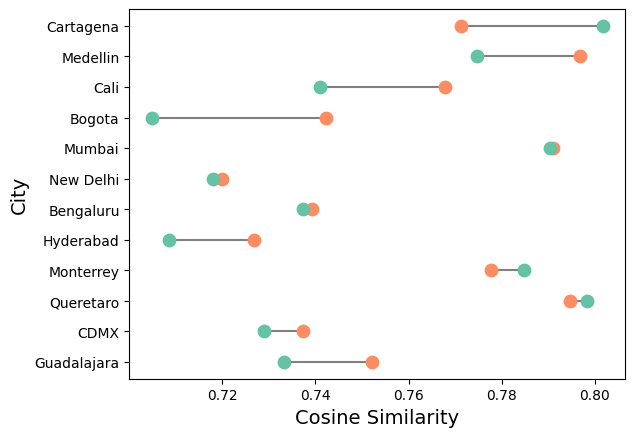

In [77]:
fig,ax = plt.subplots()
for i in range(len(compare_cities))[::-1]:
    row = compare_cities.iloc[len(compare_cities)-i-1]
    ax.plot([row.urban, row.rural], [i,i], c='grey', zorder=0)

ax.scatter(compare_cities.urban , range(12)[::-1], c=sns.palettes.color_palette('Set2')[1], s=80)
ax.scatter(compare_cities.rural , range(12)[::-1], c=sns.palettes.color_palette('Set2')[0], s=80)
ax.set_yticks(range(12),compare_cities.city[::-1])
ax.set_xlabel('Cosine Similarity', fontsize=14)
ax.set_ylabel('City', fontsize=14)


In [78]:
files = minio_helper.list_files(f'netmob_2024/processed_data/compare_countries/')
country_points = []
for f in files:
    print(f)
    csv =minio_helper.read_file(f, obj_type='csv')
    csv['area_type'] = f[-9:-4]
    country_points.append(csv)
country_points = pd.concat(country_points).reset_index(drop=True) 

/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/co_rural.csv
/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/co_urban.csv
/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/in_rural.csv
/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/in_urban.csv
/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/mx_rural.csv
/home/jupyter-niyer/README
netmob_2024/processed_data/compare_countries/mx_urban.csv
/home/jupyter-niyer/README


In [79]:
country_points['x_axis'] = country_points['0']+ country_points['area_type']
country_points.sort_values('2')

,Unnamed: 0,0,1,2,area_type,x_axis
128,12,mx,161.0,0.478228,urban,mxurban
96,32,in,378.0,0.642057,urban,inurban
19,4,co,61.0,0.646261,urban,courban
65,1,in,95.0,0.663862,urban,inurban
50,20,in,95.0,0.666283,rural,inrural
...,...,...,...,...,...,...
127,11,mx,2.0,0.812251,urban,mxurban
105,7,mx,2.0,0.815474,rural,mxrural
120,4,mx,5.0,0.853387,urban,mxurban
122,6,mx,196.0,NaN,urban,mxurban


In [81]:
import matplotlib.patches as mpatches


/tmp/ipykernel_2447848/516369706.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=country_points, x='x_axis', y='2', ax=ax,


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/country_comparison_mob_inefficiency.pdf' to bucket 'niyer-processed'.


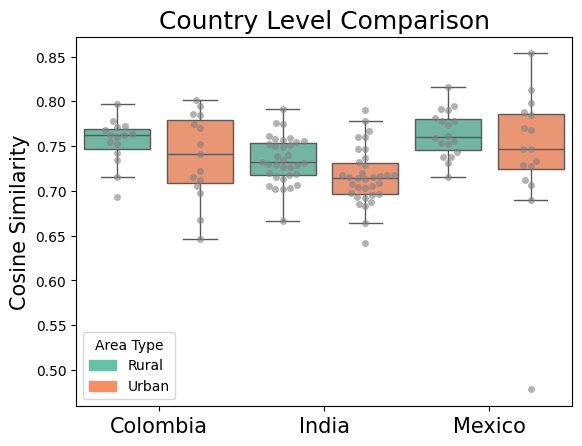

In [82]:

fig, ax= plt.subplots()
sns.boxplot(data=country_points, x='x_axis', y='2', ax=ax, 
              palette = [sns.palettes.color_palette('Set2')[1] if i%2==1 else sns.palettes.color_palette('Set2')[0] for i in range(6)],
           showfliers=False)
sns.swarmplot(data=country_points, x='x_axis', y='2', color='grey', alpha=0.6)
ax.set_ylabel('Cosine Similarity', fontsize=15)
ax.set_xticks([0.5, 2.5, 4.5], ['Colombia', 'India', 'Mexico'], fontsize=15)
red_patch = mpatches.Patch(color=sns.palettes.color_palette('Set2')[0], label='Rural')
blue_patch = mpatches.Patch(color=sns.palettes.color_palette('Set2')[1], label='Urban')

ax.legend(handles=[red_patch, blue_patch], title='Area Type')
ax.set_xlabel('')
ax.set_title('Country Level Comparison', fontsize=18)

           
buf = BytesIO()
plt.savefig(buf, format='pdf', bbox_inches='tight', transparent=True)
buf.seek(0)
minio_helper.save_file(f'netmob_2024/final_figures/processing/country_comparison_mob_inefficiency.pdf', buf, obj_type='image')